In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
sys.path.append('/global/u2/t/tvnguyen/sbi_stream')
import pickle

import corner
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import astropy.constants as const
import astropy.units as u
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm

import datasets
from sbi.utils import BoxUniform
from sbi_stream import infer_utils
from sbi_stream.npe import NPE

%matplotlib inline
plt.style.use('default.mplstyle')

/global/homes/t/tvnguyen/.conda/envs/torch-py11/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
data_root = '/pscratch/sd/t/tvnguyen/stream_sbi_shared/npe/preprocessed_datasets/AAU'
data_name = '6d-AAU-spline-sf1'
x1, y1, _, _, = datasets.read_processed_datasets(
    os.path.join(data_root, data_name),
    num_datasets=1,
    start_dataset=0,
)
x1 = x1[0]
raw_data_path = '/pscratch/sd/t/tvnguyen/stream_sbi_shared/npe/datasets/aau-ta25/data.0.hdf5'
x1_raw, _ = datasets.io_utils.read_dataset(raw_data_path, unpack=True)

100%|██████████| 1/1 [00:00<00:00, 345.24it/s]


In [3]:
data_root = '/pscratch/sd/t/tvnguyen/stream_sbi_shared/npe/preprocessed_datasets/'
data_name = '6d-uni-spline-sf1'
x2, y2, _, _  = datasets.read_processed_datasets(
    os.path.join(data_root, data_name),
    num_datasets=1,
    start_dataset=0,
)

raw_data_path = '/pscratch/sd/t/tvnguyen/stream_sbi_shared/npe/datasets/6params-uni-ta25/data.0.hdf5'
x2_raw, ptr = datasets.io_utils.read_dataset(raw_data_path, unpack=True)

100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


In [4]:
# Fit the background, find a relatively non-disturbed stream
m = y2[..., 0]
vtot = np.sqrt(y2[..., 2]**2 + y2[..., 3]**2)
idx = np.where((m < -3.8) & (vtot > 100))[0][0]

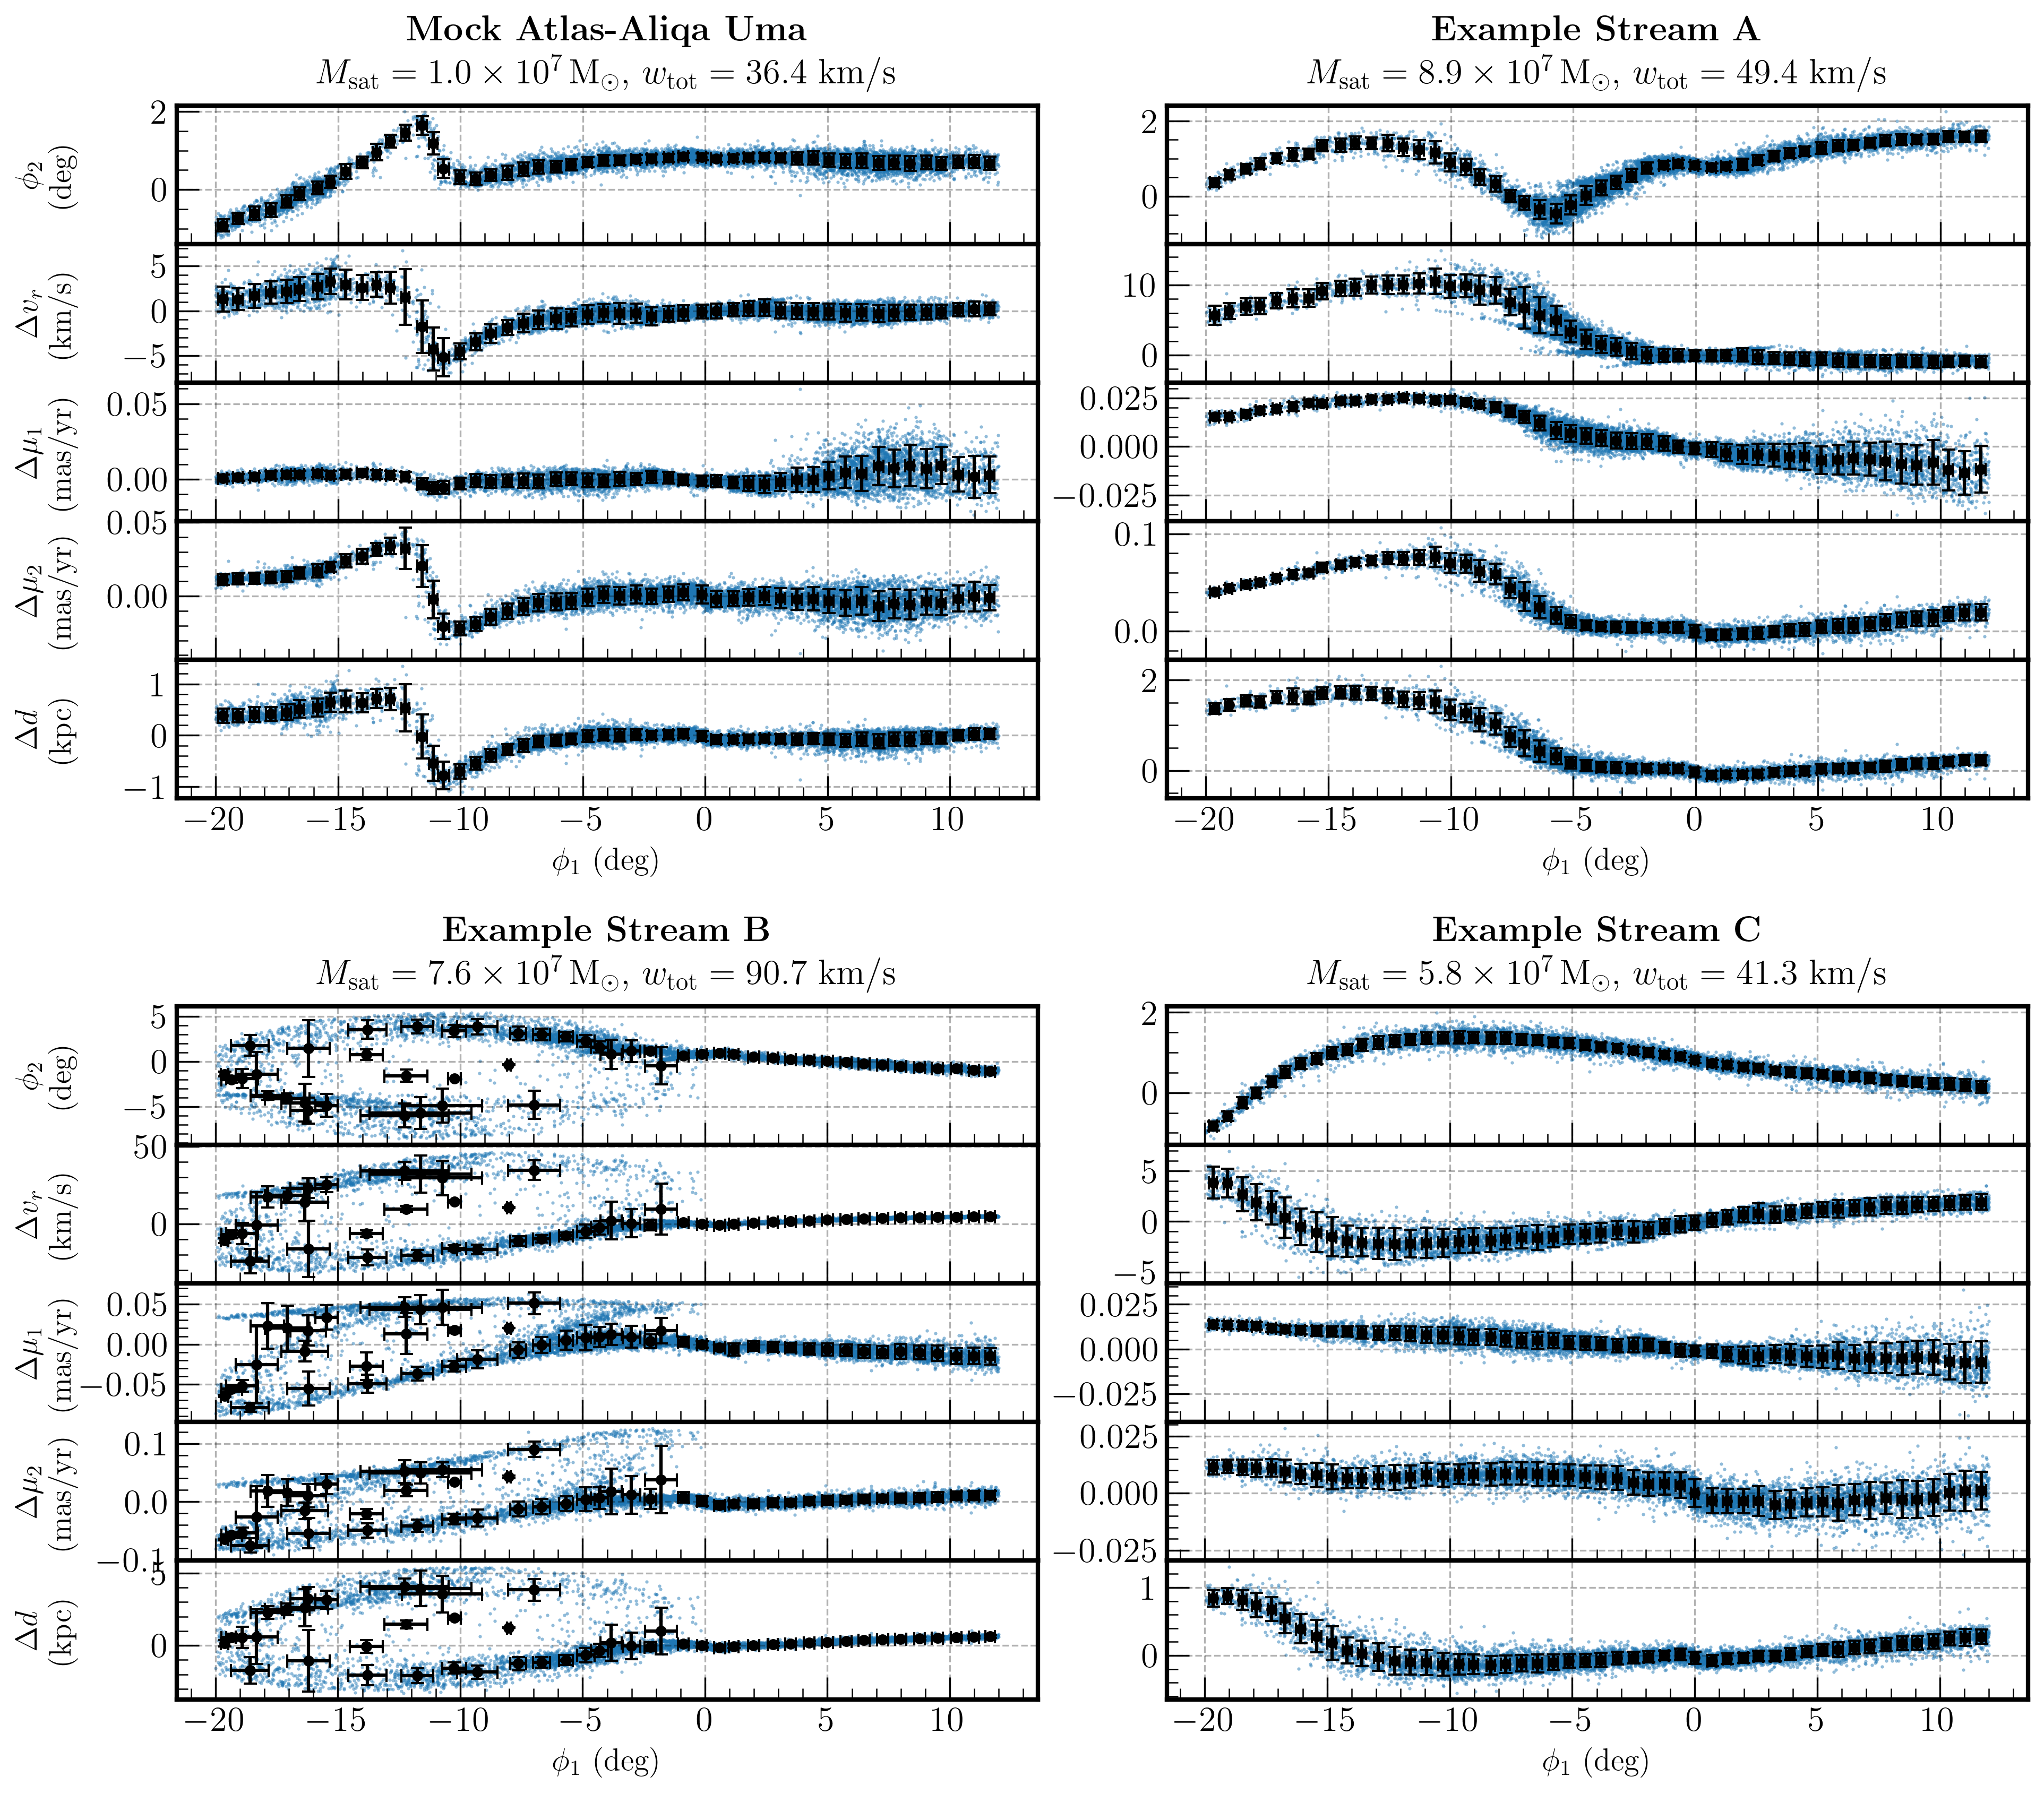

In [15]:
keys = ['phi2', 'vr', 'pm1', 'pm2', 'dist']
data_keys = ['phi2', 'rv', 'pmphi1', 'pmphi2', 'distance_kpc']
orders = [1, 4, 2, 3, 5]
xrange = (-20, 12)

# Create a nested gridspec: 2x2 grid, each 5x1 sub-gridspec
fig = plt.figure(figsize=(15, 13), dpi=300)
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.15)
axs = [gs[0, 0].subgridspec(5, 1, hspace=0), gs[0, 1].subgridspec(5, 1, hspace=0),
       gs[1, 0].subgridspec(5, 1, hspace=0), gs[1, 1].subgridspec(5, 1, hspace=0)]
axes = []
for ax in axs:
    ax_arr = []
    for i in range(5):
        if i == 0:
            ax_arr.append(fig.add_subplot(ax[i, 0]))
        else:
            ax_arr.append(fig.add_subplot(ax[i, 0], sharex=ax_arr[0]))
    axes.append(ax_arr)

idx1, idx2, idx3 = 2, 7, 50

for i, k in enumerate(keys):
    # first, fit the polynomial to the background
    # fit a forth-order polynomial to the background
    if i == 0:
        # no background subtraction for phi2
        bg_fn = lambda x: np.zeros_like(x)
    else:
        xbg = x2_raw['phi1'][idx]
        ybg = x2_raw[k][idx]
        coeff = np.polyfit(xbg, ybg, 4)
        bg_fn = np.poly1d(coeff)

    xx1 = x1_raw['phi1'][0]
    xx2 = x1_raw[k][0]
    mask = (xx1 > xrange[0]) & (xx1 < xrange[1])
    xx1 = xx1[mask]
    xx2 = xx2[mask]
    xx2_bg = bg_fn(xx1)

    axes[0][i].scatter(xx1, xx2 - xx2_bg, s=1, color='C0', marker='.', alpha=0.5, label='Raw data')
    axes[0][i].errorbar(
        x1[:, 0], x1[:, orders[i]] - bg_fn(x1[:, 0]),
        xerr=x1[:, 6], yerr=x1[:, orders[i]+6],
        fmt='o', markersize=4, color='k', capsize=3, label='Processed data')

    xx1 = x2_raw['phi1'][idx1]
    xx2 = x2_raw[k][idx1]
    mask = (xx1 > xrange[0]) & (xx1 < xrange[1])
    xx1 = xx1[mask]
    xx2 = xx2[mask]
    xx2_bg = bg_fn(xx1)
    axes[1][i].scatter(xx1, xx2 - xx2_bg, s=1, color='C0', marker='.', alpha=0.5)
    axes[1][i].errorbar(
        x2[idx1, :, 0], x2[idx1, :, orders[i]] - bg_fn(x2[idx1, :, 0]),
        xerr=x2[idx1, :, 6], yerr=x2[idx1, :, orders[i]+6],
        fmt='o', markersize=4, color='k', capsize=3)

    xx1 = x2_raw['phi1'][idx2]
    xx2 = x2_raw[k][idx2]
    mask = (xx1 > xrange[0]) & (xx1 < xrange[1])
    xx1 = xx1[mask]
    xx2 = xx2[mask]
    xx2_bg = bg_fn(xx1)
    axes[2][i].scatter(xx1, xx2 - xx2_bg, s=1, color='C0', marker='.', alpha=0.5)
    axes[2][i].errorbar(
        x2[idx2, :, 0], x2[idx2, :, orders[i]] - bg_fn(x2[idx2, :, 0]),
        xerr=x2[idx2, :, 6], yerr=x2[idx2, :, orders[i]+6],
        fmt='o', markersize=4, color='k', capsize=3)

    xx1 = x2_raw['phi1'][idx3]
    xx2 = x2_raw[k][idx3]
    mask = (xx1 > xrange[0]) & (xx1 < xrange[1])
    xx1 = xx1[mask]
    xx2 = xx2[mask]
    xx2_bg = bg_fn(xx1)
    axes[3][i].scatter(xx1, xx2 - xx2_bg, s=1, color='C0', marker='.', alpha=0.5)
    axes[3][i].errorbar(
        x2[idx3, :, 0], x2[idx3, :, orders[i]] - bg_fn(x2[idx3, :, 0]),
        xerr=x2[idx3, :, 6], yerr=x2[idx3, :, orders[i]+6],
        fmt='o', markersize=4, color='k', capsize=3)

fs = 14
for i in [0, 2]:
    axes[i][0].text(-0.15, 0.5, r'$\phi_2$' + '\n' + r'(deg)', fontsize=fs, rotation=90,
                    ha='center', va='center', transform=axes[i][0].transAxes)
    axes[i][1].text(-0.15, 0.5, r'$\Delta v_r$' + '\n' + r'(km/s)', fontsize=fs, rotation=90,
                    ha='center', va='center', transform=axes[i][1].transAxes)
    axes[i][2].text(-0.15, 0.5, r'$\Delta \mu_1$' + '\n' + r'(mas/yr)', fontsize=fs, rotation=90,
                    ha='center', va='center', transform=axes[i][2].transAxes)
    axes[i][3].text(-0.15, 0.5, r'$\Delta \mu_2$' + '\n' + r'(mas/yr)', fontsize=fs, rotation=90,
                    ha='center', va='center', transform=axes[i][3].transAxes)
    axes[i][4].text(-0.15, 0.5, r'$\Delta d$' + '\n' + r'(kpc)', fontsize=fs, rotation=90,
                    ha='center', va='center', transform=axes[i][4].transAxes)
axes[0][4].set_xlabel(r'$\phi_1$ (deg)', fontsize=fs)
axes[1][4].set_xlabel(r'$\phi_1$ (deg)', fontsize=fs)
axes[2][4].set_xlabel(r'$\phi_1$ (deg)', fontsize=fs)
axes[3][4].set_xlabel(r'$\phi_1$ (deg)', fontsize=fs)

msat = 10**(y1[0, 0] + 10)
vtotal = np.sqrt(y1[0, 2]**2 + y1[0, 3]**2)
exponent = int(np.floor(np.log10(msat)))
mantissa = msat / (10**exponent)
axes[0][0].set_title(
    f'$M_{{\\rm sat}} = {mantissa:.1f} \\times 10^{{{exponent}}} \, \mathrm{{M}}_\\odot$, '
    f'$w_{{\\rm tot}} = {vtotal:.1f} \\ \\mathrm{{km/s}}$', fontsize=16
)
msat = 10**(y2[idx1, 0] + 10)
vtotal = np.sqrt(y2[idx1, 2]**2 + y2[idx1, 3]**2)
exponent = int(np.floor(np.log10(msat)))
mantissa = msat / (10**exponent)
axes[1][0].set_title(
    f'$M_{{\\rm sat}} = {mantissa:.1f} \\times 10^{{{exponent}}} \, \mathrm{{M}}_\\odot$, '
    f'$w_{{\\rm tot}} = {vtotal:.1f} \\ \\mathrm{{km/s}}$', fontsize=16
)
msat = 10**(y2[idx2, 0] + 10)
vtotal = np.sqrt(y2[idx2, 2]**2 + y2[idx2, 3]**2)
exponent = int(np.floor(np.log10(msat)))
mantissa = msat / (10**exponent)
axes[2][0].set_title(
    f'$M_{{\\rm sat}} = {mantissa:.1f} \\times 10^{{{exponent}}} \, \mathrm{{M}}_\\odot$, '
    f'$w_{{\\rm tot}} = {vtotal:.1f} \\ \\mathrm{{km/s}}$', fontsize=16
)
msat = 10**(y2[idx3, 0] + 10)
vtotal = np.sqrt(y2[idx3, 2]**2 + y2[idx3, 3]**2)
exponent = int(np.floor(np.log10(msat)))
mantissa = msat / (10**exponent)
axes[3][0].set_title(
    f'$M_{{\\rm sat}} = {mantissa:.1f} \\times 10^{{{exponent}}} \, \mathrm{{M}}_\\odot$, '
    f'$w_{{\\rm tot}} = {vtotal:.1f} \\ \\mathrm{{km/s}}$', fontsize=16
)
axes[0][0].text(0.5, 1.42, r'\textbf{Mock Atlas-Aliqa Uma}', transform=axes[0][0].transAxes,
                ha='center', va='bottom', fontsize=16, weight='bold')
axes[1][0].text(0.5, 1.42, r'\textbf{Example Stream A}', transform=axes[1][0].transAxes,
                ha='center', va='bottom', fontsize=16, weight='bold')
axes[2][0].text(0.5, 1.42, r'\textbf{Example Stream B}', transform=axes[2][0].transAxes,
                ha='center', va='bottom', fontsize=16, weight='bold')
axes[3][0].text(0.5, 1.42, r'\textbf{Example Stream C}', transform=axes[3][0].transAxes,
                ha='center', va='bottom', fontsize=16, weight='bold')

fig.savefig('figures/example_streams_v2.pdf', bbox_inches='tight', dpi=300)
fig.savefig('figures/example_streams_v2.png', bbox_inches='tight', dpi=300)